In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

df = pd.read_excel("data_cln.xlsx")
data=df.copy(deep=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1430 entries, 0 to 1429
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    1430 non-null   int64  
 1   product_title                 1430 non-null   object 
 2   price                         1430 non-null   float64
 3   retail_price                  1430 non-null   int64  
 4   units_sold                    1430 non-null   int64  
 5   uses_ad_boosts                1430 non-null   int64  
 6   rating                        1430 non-null   float64
 7   rating_count                  1430 non-null   int64  
 8   rating_five_count             1430 non-null   int64  
 9   rating_four_count             1430 non-null   int64  
 10  rating_three_count            1430 non-null   int64  
 11  rating_two_count              1430 non-null   int64  
 12  rating_one_count              1430 non-null   int64  
 13  bad

In [33]:
rating = np.array(df['rating'])
q1,q2,q3 = np.percentile(rating,(25,50,75)).astype('int')
us = np.array(df['units_sold'])
Q1,Q2,Q3 = np.percentile(us,(25,50,75)).astype('int')

## Label Encoding

In [34]:
from sklearn.preprocessing import LabelEncoder

In [35]:
#drop 不必要的欄位 
modelData=data.drop(['product_title','tags','Unnamed: 0','urgency_text','merchant_title','merchant_info_subtitle','product_id','theme'],axis=1)

#為數值型資料做label
labelencoder = LabelEncoder()
modelData['product_color'] = labelencoder.fit_transform(modelData['product_color'].astype('str'))
modelData['product_variation_size_id'] = labelencoder.fit_transform(modelData['product_variation_size_id'].astype('str'))
modelData['origin_country'] = labelencoder.fit_transform(modelData['origin_country'].astype('str'))

modelData.head()

,price,retail_price,units_sold,uses_ad_boosts,rating,rating_count,rating_five_count,rating_four_count,rating_three_count,rating_two_count,...,product_variation_size_id,product_variation_inventory,shipping_price,shipping_is_express,countries_shipped_to,has_urgency_banner,origin_country,merchant_rating_count,merchant_rating,merchant_has_profile_picture
0,16.00,14,100,0,3.76,54,26,8,10,1,...,39,50,4,0,34,1,0,568,4.128521,0
1,8.00,22,20000,1,3.45,6135,2269,1027,1118,644,...,76,50,2,0,41,1,0,17752,3.899673,0
2,8.00,43,100,0,3.57,14,5,4,2,0,...,76,1,3,0,36,1,0,295,3.989831,0
3,8.00,8,5000,1,4.03,579,295,119,87,42,...,39,50,2,0,41,0,0,23832,4.020435,0
4,2.72,3,100,1,3.10,20,6,4,2,2,...,43,1,1,0,35,1,0,14482,4.001588,0


In [36]:
modelData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1430 entries, 0 to 1429
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   price                         1430 non-null   float64
 1   retail_price                  1430 non-null   int64  
 2   units_sold                    1430 non-null   int64  
 3   uses_ad_boosts                1430 non-null   int64  
 4   rating                        1430 non-null   float64
 5   rating_count                  1430 non-null   int64  
 6   rating_five_count             1430 non-null   int64  
 7   rating_four_count             1430 non-null   int64  
 8   rating_three_count            1430 non-null   int64  
 9   rating_two_count              1430 non-null   int64  
 10  rating_one_count              1430 non-null   int64  
 11  badges_count                  1430 non-null   int64  
 12  badge_local_product           1430 non-null   int64  
 13  bad

## K-means 分群商品

In [46]:
modelData['badge_product_quality']

0       0
1       0
2       0
3       0
4       0
       ..
1425    0
1426    1
1427    0
1428    0
1429    0
Name: badge_product_quality, Length: 1430, dtype: object

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.



Text(0, 0.5, 'kmeans inertia')

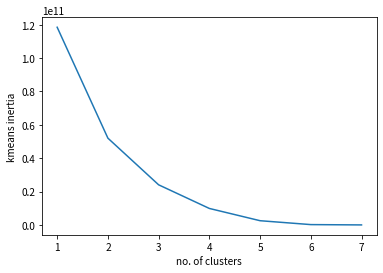

In [37]:
from sklearn.cluster import KMeans

#手肘圖
clusters = {}
for i in range(1,8):
    kmeans=KMeans(n_clusters=i)
    kmeans=kmeans.fit(modelData[['units_sold','rating']])
    clusters[i] = kmeans.inertia_
    
plt.plot(list(clusters.keys()), list(clusters.values()))
#Inertia實際上計算cluster內所有點到該cluster的質心的距離的總和 （所以數值越大代表差距越大）

plt.xlabel('no. of clusters')
plt.ylabel('kmeans inertia')

In [38]:
#order cluster method
#只是將資料依照target欄位，將cluster結果做排序（可不用理會）
def order_cluster(cluster_field_name, target_field_name, df, ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [39]:
#實際將資料分三群
modelData['units_sold_cluster']=KMeans(n_clusters=3).fit(modelData[['units_sold','rating']]).predict(modelData[['units_sold','rating']])
modelData = order_cluster('units_sold_cluster','units_sold', modelData, True)
modelData.groupby(['units_sold_cluster'])['units_sold'].describe()
display(modelData)
modelData.to_excel("Clustered.xlsx")

,price,retail_price,units_sold,uses_ad_boosts,rating,rating_count,rating_five_count,rating_four_count,rating_three_count,rating_two_count,...,product_variation_inventory,shipping_price,shipping_is_express,countries_shipped_to,has_urgency_banner,origin_country,merchant_rating_count,merchant_rating,merchant_has_profile_picture,units_sold_cluster
0,16.00,14,100,0,3.76,54,26,8,10,1,...,50,4,0,34,1,0,568,4.128521,0,0
1,8.00,43,100,0,3.57,14,5,4,2,0,...,1,3,0,36,1,0,295,3.989831,0,0
2,8.00,8,5000,1,4.03,579,295,119,87,42,...,50,2,0,41,0,0,23832,4.020435,0,0
3,2.72,3,100,1,3.10,20,6,4,2,2,...,1,1,0,35,1,0,14482,4.001588,0,0
4,3.92,9,10,0,5.00,1,1,0,0,0,...,1,1,0,40,0,0,65,3.507692,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1425,9.00,8,50000,0,3.83,13198,6060,2562,2214,1033,...,50,3,0,53,0,0,37076,4.302082,1,2
1426,6.00,6,50000,0,4.20,12880,7337,2647,1643,623,...,18,2,0,53,0,0,38264,4.227943,0,2
1427,11.00,10,50000,0,3.91,13488,6325,3006,1998,916,...,50,3,0,31,0,0,17816,4.179445,1,2
1428,5.67,19,100000,0,3.53,18393,6769,3404,3658,2003,...,50,1,0,37,1,0,19248,3.889131,0,2


In [40]:
modelData['units_sold_cluster']=modelData['units_sold_cluster'].astype('int')
modelData['badge_product_quality']=modelData['badge_product_quality'].astype('str')

In [41]:
modelData.groupby('units_sold_cluster')[['rating','units_sold']].describe().T

units_sold_cluster             0             1              2
rating     count     1314.000000     97.000000      19.000000
           mean         3.772527      3.891959       3.926316
           std          0.488379      0.281161       0.236953
           min          1.000000      2.970000       3.450000
           25%          3.500000      3.680000       3.820000
           50%          3.820000      3.930000       3.930000
           75%          4.087500      4.090000       4.055000
           max          5.000000      4.480000       4.410000
units_sold count     1314.000000     97.000000      19.000000
           mean      2407.609589  20000.000000   63157.894737
           std       3359.866699      0.000000   22620.696418
           min          0.000000  20000.000000   50000.000000
           25%        100.000000  20000.000000   50000.000000
           50%       1000.000000  20000.000000   50000.000000
           75%       5000.000000  20000.000000   75000.000000
           max      10000.000000  20000.000000  100000.000000

In [42]:
!pip install plotly
import plotly.express as px
px.scatter(modelData,x='units_sold',y='rating', color='units_sold_cluster', marginal_y ='box',title='Rating vs units sold')

In [12]:
modelData.groupby('units_sold_cluster')[['rating','price','retail_price','units_sold']].describe().T

units_sold_cluster            0             1              2
rating       count  1146.000000    265.000000      19.000000
             mean      3.755410      3.890264       3.926316
             std       0.508838      0.286522       0.236953
             min       1.000000      2.970000       3.450000
             25%       3.470000      3.700000       3.820000
             50%       3.800000      3.930000       3.930000
             75%       4.080000      4.110000       4.055000
             max       5.000000      4.480000       4.410000
price        count  1146.000000    265.000000      19.000000
             mean      8.398717      8.472868       6.884211
             std       4.043449      3.236284       2.770807
             min       1.000000      1.770000       3.000000
             25%       5.810000      6.000000       5.000000
             50%       8.000000      8.000000       6.000000
             75%      11.000000     11.000000       8.000000
             max      49.000000     22.000000      15.000000
retail_price count  1146.000000    265.000000      19.000000
             mean     23.424084     23.354717      26.684211
             std      29.669120     35.368443      31.148484
             min       1.000000      2.000000       3.000000
             25%       7.000000      7.000000       6.000000
             50%      10.000000      9.000000      10.000000
             75%      26.000000     17.000000      40.500000
             max     252.000000    252.000000     115.000000
units_sold   count  1146.000000    265.000000      19.000000
             mean   1294.589005  13660.377358   63157.894737
             std    1802.019488   4826.314377   22620.696418
             min       0.000000  10000.000000   50000.000000
             25%     100.000000  10000.000000   50000.000000
             50%    1000.000000  10000.000000   50000.000000
             75%    1000.000000  20000.000000   75000.000000
             max    5000.000000  20000.000000  100000.000000

## 視覺化：廣告

In [17]:
color=['#FCA311','#435268']
color3=['#435268','#FCA311','#E5E5E5']

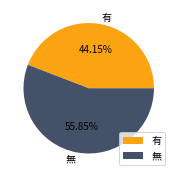

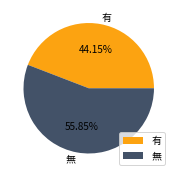

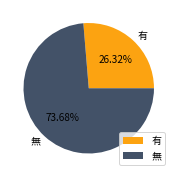

In [18]:
# 整體
for i in range(0,3):
    ad=len((modelData[(modelData['units_sold_cluster']==i)&(modelData['uses_ad_boosts']==1)]).index)
    no_ad=len(modelData[modelData['units_sold_cluster']==i].index)-ad

    plt.figure(figsize=(3,3))
    plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
    plt.pie([ad,no_ad],labels=['有','無'],colors=color,autopct = "%0.2f%%")
    plt.legend(loc = "lower right")
    plt.savefig(f"第{i}分群：有無廣告")
    plt.show()

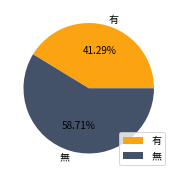

In [19]:
# 評價因子

ad=len((modelData[(modelData['units_sold_cluster']==0)&(modelData['uses_ad_boosts']==1)&(modelData['rating']>=q3)]).index)
no_ad=len(modelData[(modelData['units_sold_cluster']==0)&(modelData['rating']>=q3)].index)-ad

plt.figure(figsize=(3,3))
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
plt.pie([ad,no_ad],labels=['有','無'],colors=color,autopct = "%0.2f%%")
plt.legend(loc ='lower right')
plt.savefig("第0分群、評價大於q3：有無廣告")
plt.show()

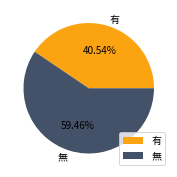

In [20]:
# 評價因子

ad=len((modelData[(modelData['units_sold_cluster']!=0)&(modelData['uses_ad_boosts']==1)&(modelData['rating']>=q3)]).index)
no_ad=len(modelData[(modelData['units_sold_cluster']!=0)&(modelData['rating']>=q3)].index)-ad

plt.figure(figsize=(3,3))
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
plt.pie([ad,no_ad],labels=['有','無'],colors=color,autopct = "%0.2f%%")
plt.legend(loc ='lower right')
plt.savefig("第1、2分群、評價大於q3：有無廣告")
plt.show()

## 視覺化：限量

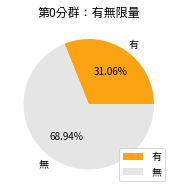

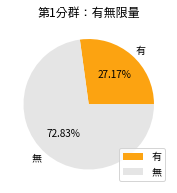

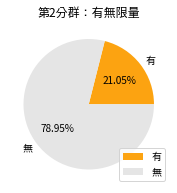

In [352]:
# 整體
for i in range(3):
    urgency=len((modelData[(modelData['units_sold_cluster']==i) & (modelData['has_urgency_banner']==1)]).index)
    no_urgency=len(modelData[modelData['units_sold_cluster']==i].index)-urgency

    plt.figure(figsize=(3,3))
    plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
    plt.pie([urgency,no_urgency],labels=['有','無'],colors=color,autopct = "%0.2f%%")
    plt.title(f"第{i}分群：有無限量")
    plt.legend(loc = "lower right")
    plt.savefig(f"第{i}分群：有無限量")
    plt.show()

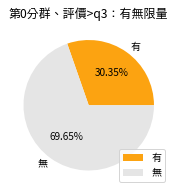

In [353]:
#評價因子

urgency=len((modelData[(modelData['units_sold_cluster']==0)&(modelData['has_urgency_banner']==1)&(modelData['rating']>=q3)]).index)
no_urgency=len(modelData[(modelData['units_sold_cluster']==0)&(modelData['rating']>=q3)].index)-urgency

plt.figure(figsize=(3,3))
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
plt.pie([urgency,no_urgency],labels=['有','無'],colors=color,autopct = "%0.2f%%")
plt.title("第0分群、評價>q3：有無限量")
plt.legend(loc ='lower right')
plt.savefig("第0分群、評價大於q3：有無限量")
plt.show()

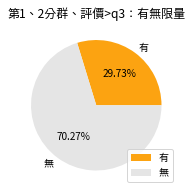

In [354]:
#評價因子

urgency=len((modelData[(modelData['units_sold_cluster']!=0)&(modelData['has_urgency_banner']==1)&(modelData['rating']>=q3)]).index)
no_urgency=len(modelData[(modelData['units_sold_cluster']!=0)&(modelData['rating']>=q3)].index)-urgency

plt.figure(figsize=(3,3))
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
plt.pie([urgency,no_urgency],labels=['有','無'],colors=color,autopct = "%0.2f%%")
plt.title("第1、2分群、評價>q3：有無限量")
plt.legend(loc ='lower right')
plt.savefig("第1、2分群、評價大於q3：有無限量")
plt.show()

## 視覺化：快速出貨

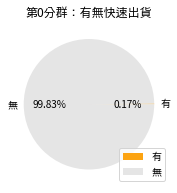

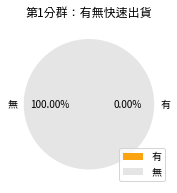

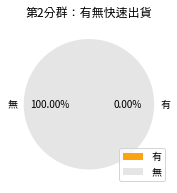

In [356]:
# 整體
for i in range(3):
    e_shipping=len((modelData[(modelData['units_sold_cluster']==i) & (modelData['shipping_is_express']==1)]).index)
    no_e_shipping=len(modelData[modelData['units_sold_cluster']==i].index)-e_shipping

    plt.figure(figsize=(3,3))
    plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
    plt.pie([e_shipping,no_e_shipping],labels=['有','無'],colors=color,autopct = "%0.2f%%")
    plt.title(f"第{i}分群：有無快速出貨")
    plt.legend(loc = "lower right")
    plt.savefig(f"第{i}分群：有無快速出貨")
    plt.show()

## 視覺化：徽章數

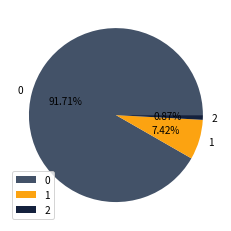

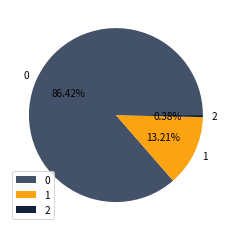

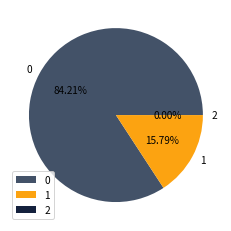

In [24]:
# 整體
cb=['#435268','#FCA311','#14213D']
for i in range(3):
    zero=len((modelData[(modelData['units_sold_cluster']==i) & (modelData['badges_count']==0)]).index)
    one=len((modelData[(modelData['units_sold_cluster']==i) & (modelData['badges_count']==1)]).index)
    two=len((modelData[(modelData['units_sold_cluster']==i) & (modelData['badges_count']==2)]).index)

    plt.pie([zero,one,two],labels=['0','1','2'],colors=cb,autopct="%0.2f%%")
    plt.legend(loc = "lower left")
    plt.savefig(f"第{i}分群：徽章數")
    plt.show()

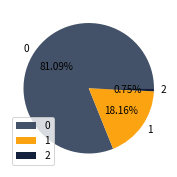

In [25]:
#評價因子

zero=len((modelData[(modelData['units_sold_cluster']==0)&(modelData['badges_count']==0)&(modelData['rating']>=q3)]).index)
one=len((modelData[(modelData['units_sold_cluster']==0)&(modelData['badges_count']==1)&(modelData['rating']>=q3)]).index)
two=len((modelData[(modelData['units_sold_cluster']==0)&(modelData['badges_count']==2)&(modelData['rating']>=q3)]).index)


plt.figure(figsize=(3,3))
plt.pie([zero,one,two],labels=['0','1','2'],colors=cb,autopct = "%0.2f%%")
plt.legend(loc = "lower left")
plt.savefig("第0分群、評價大於q3：徽章數")
plt.show()

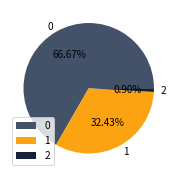

In [26]:
#評價因子

zero=len((modelData[(modelData['units_sold_cluster']!=0)&(modelData['badges_count']==0)&(modelData['rating']>=q3)]).index)
one=len((modelData[(modelData['units_sold_cluster']!=0)&(modelData['badges_count']==1)&(modelData['rating']>=q3)]).index)
two=len((modelData[(modelData['units_sold_cluster']!=0)&(modelData['badges_count']==2)&(modelData['rating']>=q3)]).index)


plt.figure(figsize=(3,3))
plt.pie([zero,one,two],labels=['0','1','2'],colors=cb,autopct = "%0.2f%%")
plt.legend(loc = "lower left")
plt.savefig("第1、2分群、評價大於q3：徽章數")
plt.show()

In [342]:
px.scatter(modelData,x='units_sold',y='rating',color='badges_count',title='評論與徽章數 散佈圖')

## 在地商家

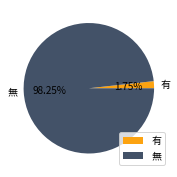

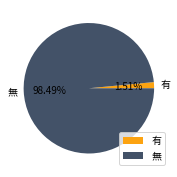

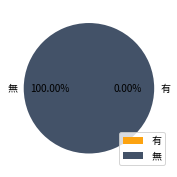

In [27]:
# 整體
for i in range(3):
    local=len((modelData[(modelData['units_sold_cluster']==i) & (modelData['badge_local_product']==1)]).index)
    no_local=len(modelData[modelData['units_sold_cluster']==i].index)-local

    plt.figure(figsize=(3,3))
    plt.pie([local,no_local],labels=['有','無'],colors=color,autopct = "%0.2f%%")
    plt.legend(loc = "lower right")
    plt.savefig(f"第{i}分群：有無在地商家徽章")
    plt.show()

## 品質徽章

In [45]:
len((modelData[(modelData['units_sold_cluster']==i) & (modelData['badge_product_quality']==0)]).index)

0

In [47]:
quality

0

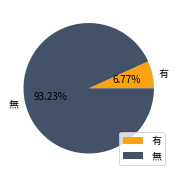

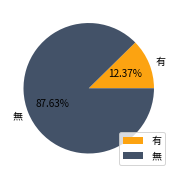

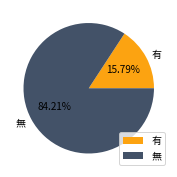

In [48]:
# 整體
for i in range(3):
    quality=len((modelData[(modelData['units_sold_cluster']==i)&(modelData['badge_product_quality']=='1')]).index)
    no_quality=len(modelData[modelData['units_sold_cluster']==i].index)-quality

    plt.figure(figsize=(3,3))
    plt.pie([quality,no_quality],labels=['有','無'],colors=color,autopct = "%0.2f%%")
    plt.legend(loc = "lower right")
    plt.savefig(f"第{i}分群：有無品質認證徽章")
    plt.show()

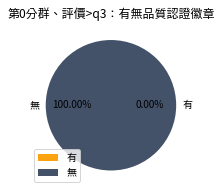

In [31]:
#評價因子

quality=len((modelData[(modelData['units_sold_cluster']==0)&(modelData['badge_product_quality']==1)&(modelData['rating']>=q3)]).index)
no_quality=len(modelData[(modelData['units_sold_cluster']==0)&(modelData['rating']>=q3)].index)-quality


plt.figure(figsize=(3,3))
plt.pie([quality,no_quality],labels=['有','無'],colors=color,autopct = "%0.2f%%")
plt.title("第0分群、評價>q3：有無品質認證徽章")
plt.legend(loc = "lower left")
plt.savefig("第0分群、評價大於q3：有無品質認證徽章")
plt.show()

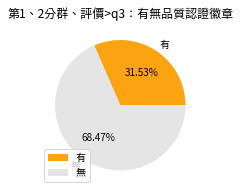

In [368]:
#評價因子

quality=len((modelData[(modelData['units_sold_cluster']!=0)&(modelData['badge_product_quality']==1)&(modelData['rating']>=q3)]).index)
no_quality=len(modelData[(modelData['units_sold_cluster']!=0)&(modelData['rating']>=q3)].index)-quality


plt.figure(figsize=(3,3))
plt.pie([quality,no_quality],labels=['有','無'],colors=color,autopct = "%0.2f%%")
plt.title("第1、2分群、評價>q3：有無品質認證徽章")
plt.legend(loc = "lower left")
plt.savefig("第1、2分群、評價大於q3：有無品質認證徽章")
plt.show()

In [191]:
px.scatter(modelData,x='rating',y='badge_product_quality',hover_name='units_sold_cluster',color='units_sold_cluster',title='評論與品質認證徽章 散佈圖')

In [233]:
px.scatter(modelData,x='units_sold',y='rating',hover_name='units_sold_cluster',color='badge_product_quality',size='units_sold',title='品質認證徽章 泡泡圖')

## 快速出貨徽章

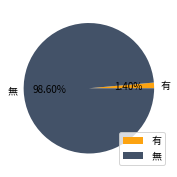

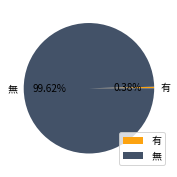

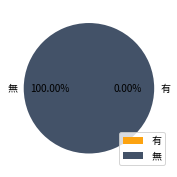

In [28]:
# 整體
for i in range(3):
    fast=len((modelData[(modelData['units_sold_cluster']==i) & (modelData['badge_fast_shipping']==1)]).index)
    no_fast=len(modelData[modelData['units_sold_cluster']==i].index)-fast

    plt.figure(figsize=(3,3))
    plt.pie([fast,no_fast],labels=['有','無'],colors=color,autopct = "%0.2f%%")
    plt.legend(loc = "lower right")
    plt.savefig(f"第{i}分群：有無快速出貨徽章")
    plt.show()

## 折扣

In [50]:
a=modelData.groupby('units_sold_cluster')[['price','retail_price']].describe().T

In [51]:
a.iloc[1,1]

8.716288659793813

In [52]:
on_sale

[]

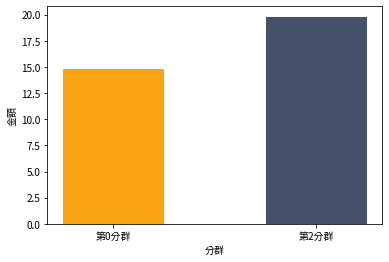

In [54]:
on_sale=[]
for i in [0,2]:
    on_sale.append(a.iloc[9,i]-a.iloc[1,i])

plt.bar(["第0分群","第2分群"],on_sale,color=color,width=0.5)
plt.xlabel("分群")
plt.ylabel("金額")
plt.savefig('平均折扣價錢 長條圖')
plt.show()

In [130]:
# 盒狀圖
modelData['on_sale']=modelData['retail_price']-modelData['price']
px.box(modelData,x='units_sold_cluster',y='on_sale',title='on sale&cluster Box Plot')

In [219]:
px.scatter(modelData, x='retail_price', y='price',color='units_sold_cluster',marginal_y='box',title="零售價/價錢 泡泡圖",size='units_sold', size_max=60)

## 賣家評價

In [214]:
px.scatter(modelData,x='units_sold',y='rating',color='units_sold_cluster',size='merchant_rating',title='賣家評論 泡泡圖')

## 運送國家數量

In [303]:
px.scatter(modelData,'units_sold','countries_shipped_to',color='units_sold_cluster',marginal_y='box',
           title='運送國家數量 泡泡圖')

## 機器學習分類

In [162]:
from sklearn.model_selection import train_test_split

X=modelData.drop(['units_sold'],axis=1)
y=modelData['units_sold']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=2)

In [166]:
#處理tag

data['tags'].str.split(',').get(0)

#提詞
def word_extraction(tag, split): 
#將tags切割逗號，轉為list
    words = tag.split(split)
    for w in words:
        cleaned_text = [w.lower()] 
    return cleaned_text

def tokenize(data, column, split): 
    wordfreq = {}
    for tag in data[column]: 
        words = word_extraction(tag, split)
        for word in words:
            if word not in wordfreq.keys():
                wordfreq[word] = 1
            else:
                wordfreq[word] += 1
    return wordfreq

tagfreq = tokenize(data, 'tags', ',')
tag_data = pd.DataFrame.from_dict(dict(tagfreq), orient='index').reset_index().rename(index=str, columns={0:'value', 'index':'tag'})
tag_data = tag_data.sort_values(['value'],ascending=False)
tag_data.head()

#upload = files.upload() 
#tag_label_data = pd.read_csv(io.StringIO(upload['tags.csv'].decode('utf-8')))

,tag,value
4,women,405
13,casual dress,89
15,cotton,82
1,casual,70
5,jumpsuit,64


## 決策樹

決策樹的精準度： 0.7657342657342657


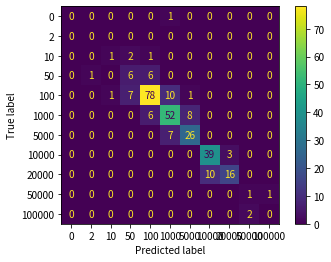

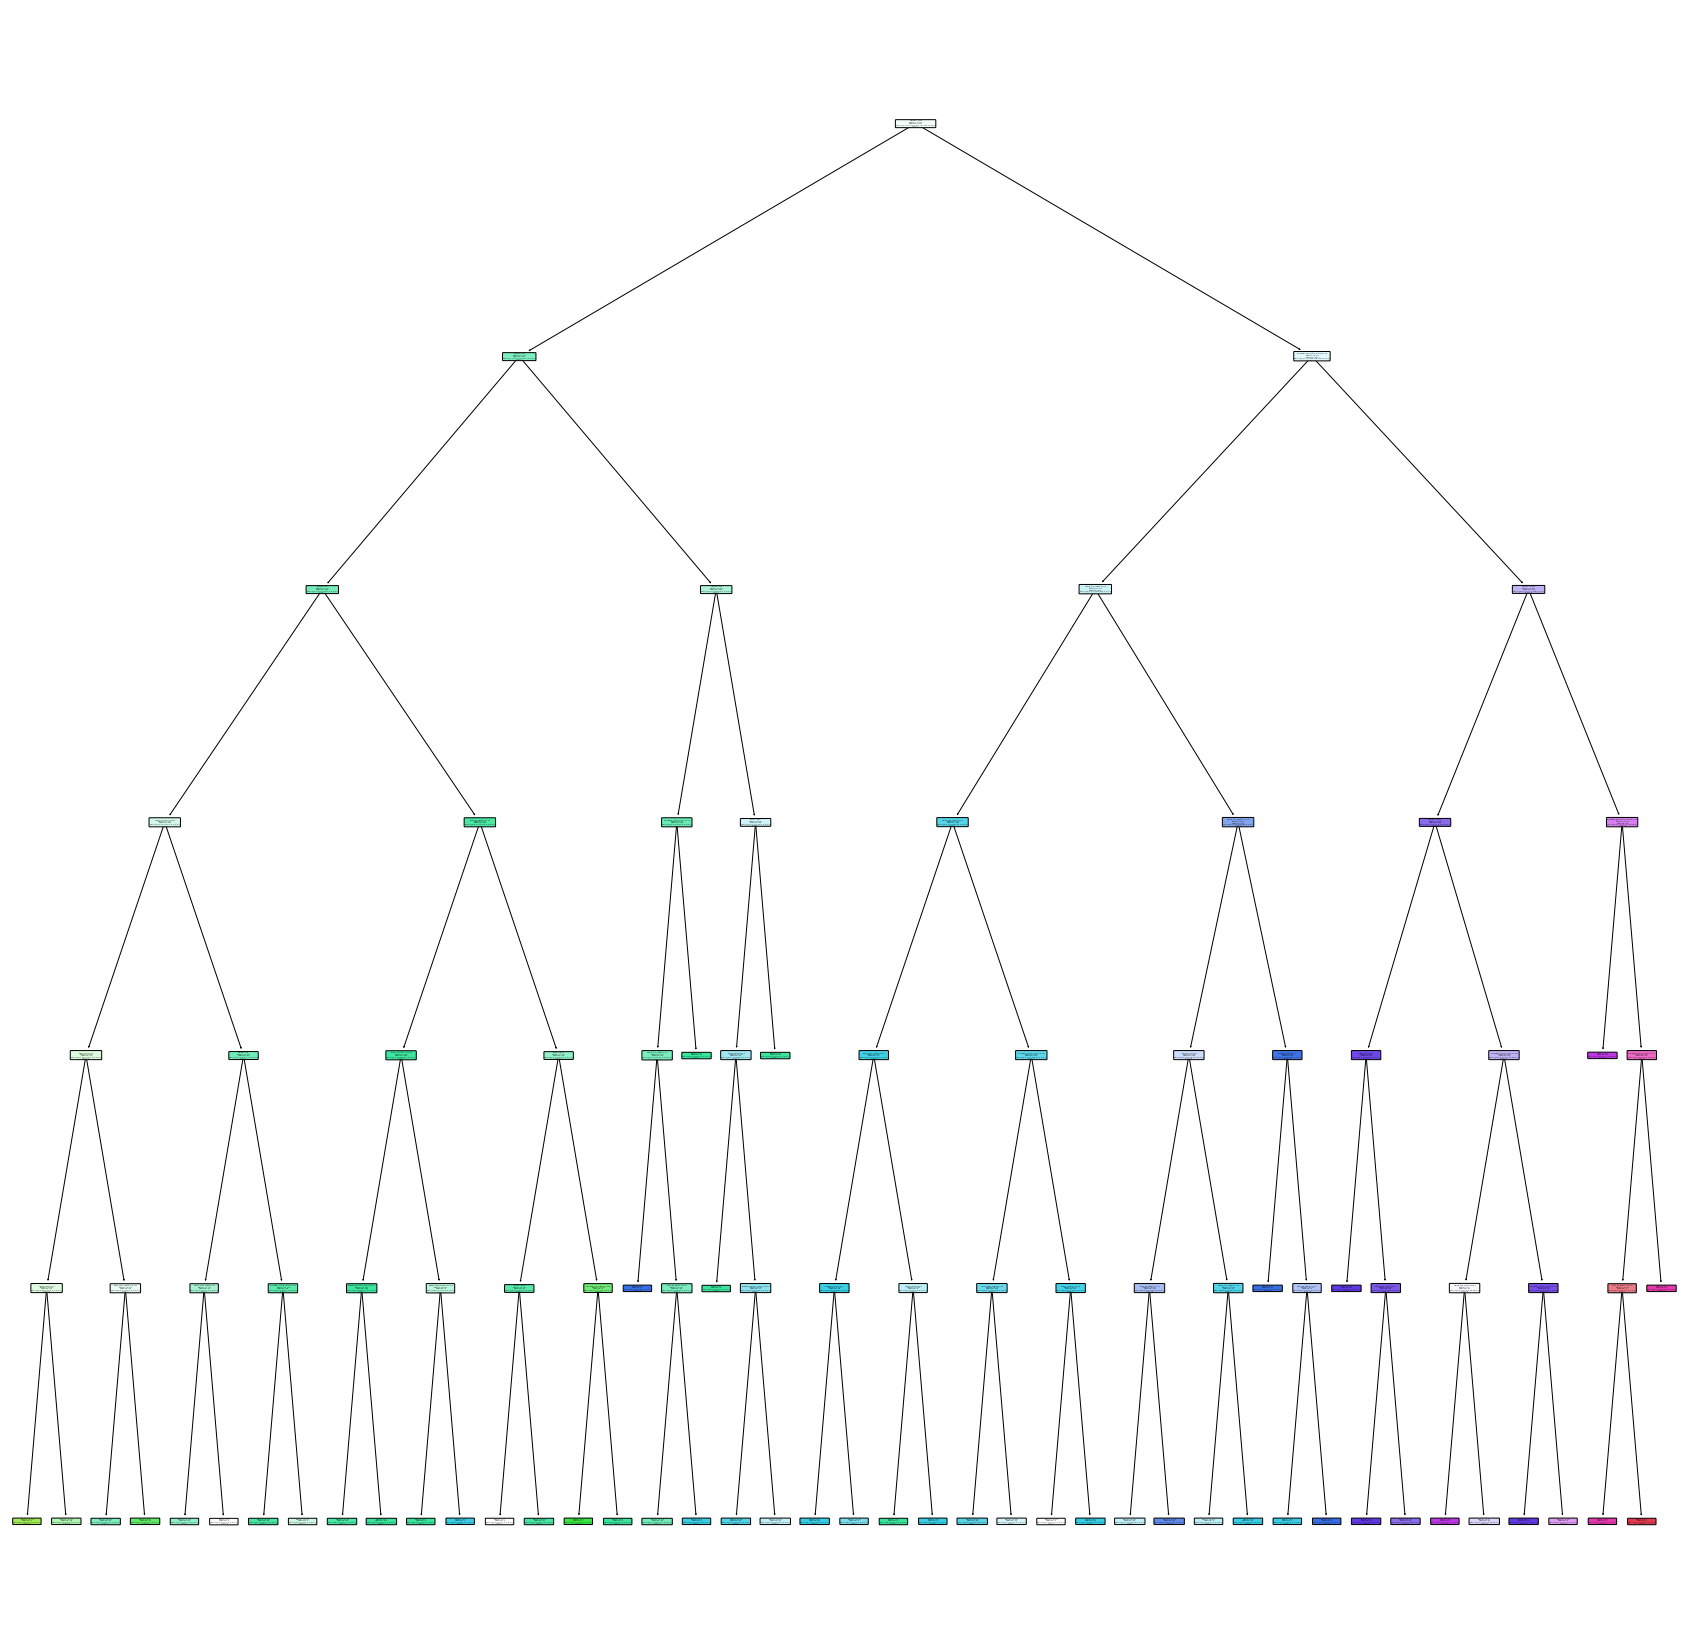

In [173]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

decisionTreeModel=DecisionTreeClassifier(criterion = 'entropy', max_depth=6, random_state=20)
decisionTreeModel.fit(X_train,y_train)

y_predict=decisionTreeModel.predict(X_test)
accuracy=metrics.accuracy_score(y_test,y_predict)
print("決策樹的精準度：",accuracy)

from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(decisionTreeModel, X_test, y_test)  

target_names = modelData['units_sold'].unique().tolist()
from IPython.core.pylabtools import figsize
from sklearn.tree import plot_tree 

fig, ax = plt.subplots(figsize = (30,30))
plot_tree(decisionTreeModel,
          ax= ax, 
          feature_names = modelData.columns, 
          class_names = str(target_names),
          filled = True,
          rounded = True)

plt.savefig('tree_visualization.png') 

## 隨機森林

隨機森林的精準度： 0.8531468531468531


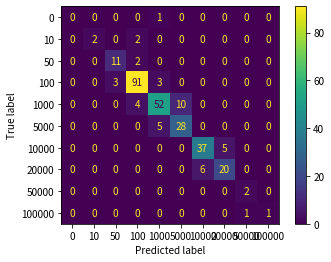

In [177]:
from sklearn.ensemble import RandomForestClassifier

randomForestModel=RandomForestClassifier(n_estimators=100,criterion='gini')
randomForestModel.fit(X_train, y_train)

y_predict=randomForestModel.predict(X_test)

accuracy = metrics.accuracy_score(y_test,y_predict)
print("隨機森林的精準度：",accuracy)

plot_confusion_matrix(randomForestModel, X_test, y_test)  

## SVC

SVC的精準度： 0.4405594405594406


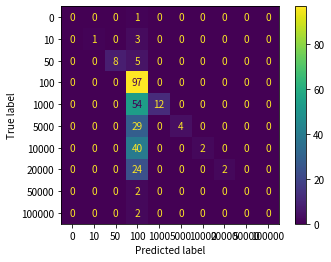

In [186]:
from sklearn import svm
clf=svm.SVC(kernel='rbf',C=1,gamma='auto')
clf.fit(X_train,y_train)

y_predict=clf.predict(X_test)

accuracy=metrics.accuracy_score(y_test,y_predict)
print("SVC的精準度：",accuracy)

plot_confusion_matrix(clf, X_test, y_test)  

## XGBoost

In [249]:
!pip install xgboost
from xgboost import XGBClassifier

[20:32:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost的精準度： 0.8391608391608392


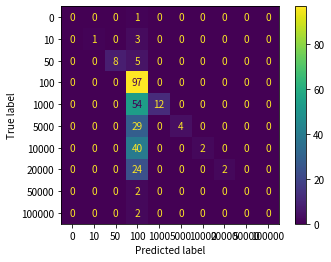

In [253]:
xgbr = XGBClassifier()
xgbr.fit(X_train, y_train)

y_predict=xgbr.predict(X_test)

accuracy=accuracy_score(y_test,y_predict)
print("XGBoost的精準度：",accuracy)

plot_confusion_matrix(clf, X_test, y_test)  

## 邏輯回歸

邏輯迴歸的精準度： 0.4230769230769231


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



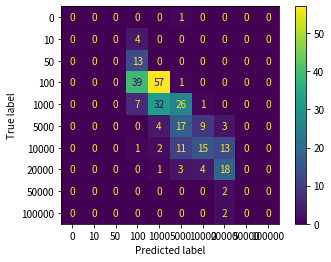

In [254]:
from sklearn import linear_model

model=linear_model.LogisticRegression()
model.fit(X_train,y_train)

y_predict=model.predict(X_test)

accuracy=accuracy_score(y_test,y_predict)
print("邏輯迴歸的精準度：",accuracy)

plot_confusion_matrix(model, X_test, y_test)  